In [ ]:
#this code is referenced from the official tutorial

# Object Detection

In this tutorial, you will learn:
- to perform inference with a MMDetection detector.
- to train a new detector with a new dataset.

In [1]:
cd mmdetection

/home/z890/Downloads/ml_sample_develop/carasml/detection/mm_RtmDet/mmdetection


/home/z890/.conda/envs/mm_rtm/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


## Import MMDetection

In [3]:
# We download the pre-trained checkpoints for inference and finetuning.
!mkdir ./checkpoint
!mkdir ./output

In [4]:
# there are plenty of models
# you may check what models are available on
# https://mmdetection.readthedocs.io/en/latest/modelzoo_statistics.html

In [3]:
!mim download mmdet --config rtmdet_tiny_8xb32-300e_coco --dest ./checkpoint

processing rtmdet_tiny_8xb32-300e_coco...
rtmdet_tiny_8xb32-300e_coco_20220902_112414-78e30dcc.pth exists in /home/z890/Downloads/ml_sample_develop/carasml/detection/mm_RtmDet/mmdetection/checkpoint
Successfully dumped rtmdet_tiny_8xb32-300e_coco.py to /home/z890/Downloads/ml_sample_develop/carasml/detection/mm_RtmDet/mmdetection/checkpoint


The above code downloads weights of a pretrained model <br>
if it was not successful <br>
please go to terminal, and run: <br>
conda activate "your environment name" <br>
cd mmdetection <br>
mim download mmdet --config rtmdet_tiny_8xb32-300e_coco --dest ./checkpoint

## Train with customized datasets

In this part, you will know how to train predefined models with customized datasets and then test it. We use the [balloon dataset](https://github.com/matterport/Mask_RCNN/tree/master/samples/balloon) as an example to describe the whole process.

The basic steps are as below:

1. Prepare the customized dataset
2. Prepare a config
3. Train, test, and infer models on the customized dataset.


### Prepare the customized dataset

There are three ways to support a new dataset in MMDetection:

1. Reorganize the dataset into COCO format.
2. Reorganize the dataset into a middle format.
3. Implement a new dataset.

Usually, we recommend using the first which is usually easier.

In this tutorial, we use the ballon dataset an example of converting the data into COCO format.

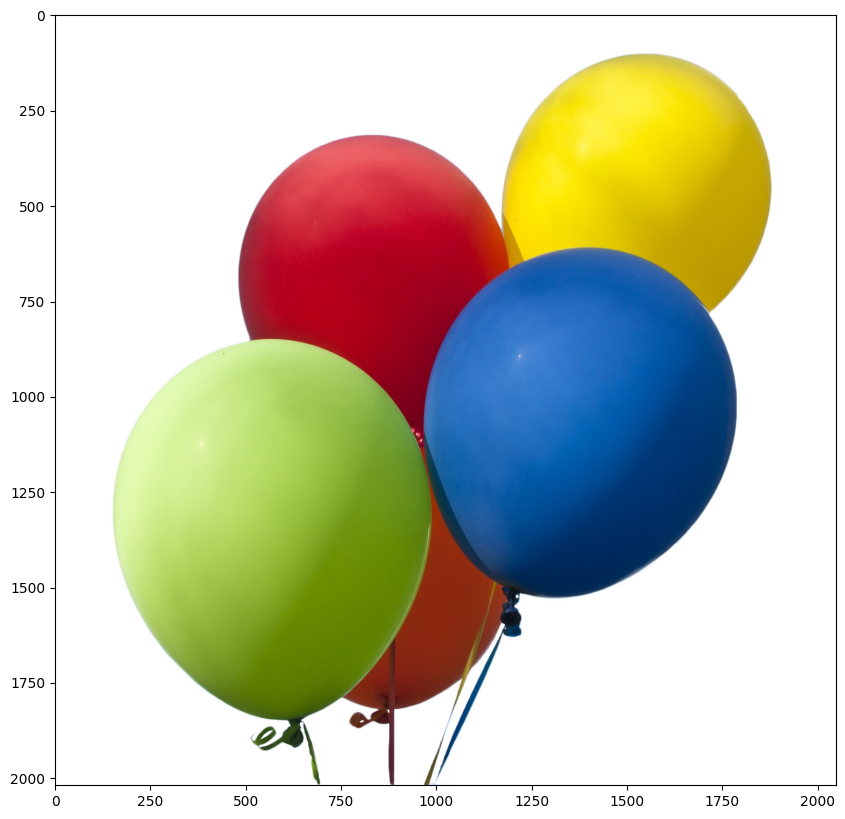

In [11]:
# Let's take a look at the dataset image
import mmcv
import matplotlib.pyplot as plt

img = mmcv.imread('data/balloon/train/10464445726_6f1e3bbe6a_k.jpg')
plt.figure(figsize=(15, 10))
plt.imshow(mmcv.bgr2rgb(img))
plt.show()

#### COCO annotation format
The necessary keys of COCO format for instance segmentation are as below, for the complete details, please refer [here](https://cocodataset.org/#format-data).
This case we only do detection, so "segmentation" can be set to None.

```json
{
    "images": [image],
    "annotations": [annotation],
    "categories": [category]
}
image = {
    "id": int,
    "width": int,
    "height": int,
    "file_name": str,
}
annotation = {
    "id": int,
    "image_id": int,
    "category_id": int,
    "segmentation": RLE or [polygon],
    "area": float,
    "bbox": [x,y,width,height], # (x, y) are the coordinates of the upper left corner of the bbox
    "iscrowd": 0 or 1,
}
categories = [{
    "id": int,
    "name": str,
    "supercategory": str,
}]
```

Assume we use the balloon dataset.
After downloading the data, we need to implement a function to convert the annotation format into the COCO format. Then we can use implemented `CocoDataset` to load the data and perform training and evaluation.

If you take a look at the dataset, you will find the dataset format is as below:

```json
{'base64_img_data': '',
 'file_attributes': {},
 'filename': '34020010494_e5cb88e1c4_k.jpg',
 'fileref': '',
 'regions': {'0': {'region_attributes': {},
   'shape_attributes': {'all_points_x': [1020,
     1000,
     994,
     1003,
     1023,
     1050,
     1089,
     1134,
     1190,
     1265,
     1321,
     1361,
     1403,
     1428,
     1442,
     1445,
     1441,
     1427,
     1400,
     1361,
     1316,
     1269,
     1228,
     1198,
     1207,
     1210,
     1190,
     1177,
     1172,
     1174,
     1170,
     1153,
     1127,
     1104,
     1061,
     1032,
     1020],
    'all_points_y': [963,
     899,
     841,
     787,
     738,
     700,
     663,
     638,
     621,
     619,
     643,
     672,
     720,
     765,
     800,
     860,
     896,
     942,
     990,
     1035,
     1079,
     1112,
     1129,
     1134,
     1144,
     1153,
     1166,
     1166,
     1150,
     1136,
     1129,
     1122,
     1112,
     1084,
     1037,
     989,
     963],
    'name': 'polygon'}}},
 'size': 1115004}
```

The annotation is a JSON file where each key indicates an image's all annotations.
The code to convert the balloon dataset into coco format is as below.

Using the function below, users can successfully convert the annotation file into json format, then we can use `CocoDataset` to train and evaluate the model with `CocoMetric`.

In [12]:
import os.path as osp
import mmcv
from mmengine.fileio import dump, load
from mmengine.utils import track_iter_progress

def convert_balloon_to_coco(ann_file, out_file, image_prefix):
    data_infos = load(ann_file)

    annotations = []
    images = []
    obj_count = 0
    data_infos = list(data_infos.values())
    for idx, v in enumerate(track_iter_progress(data_infos)):
        filename = v['filename']
        img_path = osp.join(image_prefix, filename)
        height, width = mmcv.imread(img_path).shape[:2]

        images.append(
            dict(id=idx, file_name=filename, height=height, width=width))

        for _, obj in v['regions'].items():
            assert not obj['region_attributes']
            obj = obj['shape_attributes']
            px = obj['all_points_x']
            py = obj['all_points_y']
            #poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)] # we dont need poly when doing detection
            #poly = [p for x in poly for p in x]

            x_min, y_min, x_max, y_max = (min(px), min(py), max(px), max(py))

            data_anno = dict(
                image_id=idx,
                id=obj_count,
                category_id=0,
                bbox=[x_min, y_min, x_max - x_min, y_max - y_min],
                area=(x_max - x_min) * (y_max - y_min),
                #segmentation=[poly],
                iscrowd=0)
            annotations.append(data_anno)
            obj_count += 1

    coco_format_json = dict(
        images=images,
        annotations=annotations,
        categories=[{
            'id': 0,
            'name': 'balloon'
        }])
    dump(coco_format_json, out_file)

convert_balloon_to_coco(ann_file='data/balloon/train/via_region_data.json',
                        out_file='data/balloon/train.json',
                        image_prefix='data/balloon/train')
convert_balloon_to_coco(ann_file='data/balloon/val/via_region_data.json',
                        out_file='data/balloon/val.json',
                        image_prefix='data/balloon/val')

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 61/61, 147.1 task/s, elapsed: 0s, ETA:     0s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 13/13, 142.8 task/s, elapsed: 0s, ETA:     0s


## Prepare a config

The second step is to prepare a config thus the dataset could be successfully loaded. Assume that we want to use RTMDet-tiny, the config to train the detector on balloon dataset is as below. Assume the config is under directory `configs/rtmdet/` and named as `rtmdet_tiny_1xb4-20e_balloon.py`, the config is as below.


In [13]:
# set configs for our model
# please revise the details inside for your task, take attention to #
# if you have no idea how to revise, just set %run tools/train.py configs/rtmdet/rtmdet_tiny_1xb4-20e.py first
# it will generate the used configs in work_dirs/
# then, you can copy the part that need to be revised and edit on it
# for more augmentation, you can refer to
# https://mmdetection.readthedocs.io/en/v2.19.1/tutorials/data_pipeline.html
# https://mmdetection.readthedocs.io/en/v2.16.0/_modules/mmdet/datasets/pipelines/transforms.html
# for mixup and mosaic
# https://mmdetection.readthedocs.io/en/latest/advanced_guides/how_to.html#use-mosaic-augmentation

config_balloon = """
# set model name
_base_ = './rtmdet_tiny_8xb32-300e_coco.py'

# dataset location
data_root = 'data/balloon/'

# Training parameters, set according to you device capacity
train_batch_size_per_gpu = 4
train_num_workers = 2

max_epochs = 20
stage2_num_epochs = 1
base_lr = 0.00008

metainfo = {
    'classes': ('balloon', ), # names of classes
    'palette': [              # any color you want
        (220, 20, 60),
    ]
}

# customed augmentation
train_pipeline=[
    dict(backend_args=None, type='LoadImageFromFile'),
    dict(type='LoadAnnotations', with_bbox=True, with_label=True),
    dict(
        img_scale=(
            640,
            640,
        ),
        max_cached_images=20,
        pad_val=114.0,
        random_pop=False,
        type='CachedMosaic'),
    dict(
        keep_ratio=True,
        ratio_range=(
            0.5,
            2.0,
        ),
        scale=(
            1280,
            1280,
        ),
        type='RandomResize'),
    dict(crop_size=(
        640,
        640,
    ), type='RandomCrop'),
    dict(type='YOLOXHSVRandomAug'),
    dict(prob=0.5, type='RandomFlip'),
    dict(
        pad_val=dict(img=(
            114,
            114,
            114,
        )),
        size=(
            640,
            640,
        ),
        type='Pad'),
    dict(
        img_scale=(
            640,
            640,
        ),
        max_cached_images=10,
        pad_val=(
            114,
            114,
            114,
        ),
        prob=0.5,
        random_pop=False,
        ratio_range=(
            1.0,
            1.0,
        ),
        type='CachedMixUp'),
    dict(type='PackDetInputs'),
]

train_dataloader = dict(
    batch_size=train_batch_size_per_gpu,
    num_workers=train_num_workers,
    dataset=dict(
        data_root=data_root,
        metainfo=metainfo,
        data_prefix=dict(img='train/'),
        ann_file='train.json',
        pipeline=train_pipeline))

val_dataloader = dict(
    dataset=dict(
        data_root=data_root,
        metainfo=metainfo,
        data_prefix=dict(img='val/'),
        ann_file='val.json'))

test_dataloader = val_dataloader

val_evaluator = dict(ann_file=data_root + 'val.json')

test_evaluator = val_evaluator

model = dict(bbox_head=dict(num_classes=1)) # number of classes 

# learning rate
param_scheduler = [
    dict(
        type='LinearLR',
        start_factor=1.0e-5,
        by_epoch=False,
        begin=0,
        end=10),
    dict(
        # use cosine lr from 10 to 20 epoch
        type='CosineAnnealingLR',
        eta_min=base_lr * 0.05,
        begin=max_epochs // 2,
        end=max_epochs,
        T_max=max_epochs // 2,
        by_epoch=True,
        convert_to_iter_based=True),
]

# optimizer
optim_wrapper = dict(
    _delete_=True,
    type='OptimWrapper',
    optimizer=dict(type='AdamW', lr=base_lr, weight_decay=0.05),
    paramwise_cfg=dict(
        norm_decay_mult=0, bias_decay_mult=0, bypass_duplicate=True))

default_hooks = dict(
    checkpoint=dict(
        interval=5,
        max_keep_ckpts=2,  
        save_best='auto'
    ),
    logger=dict(type='LoggerHook', interval=5))

# load pre-trained weight
load_from = './checkpoint/rtmdet_tiny_8xb32-300e_coco_20220902_112414-78e30dcc.pth'

train_cfg = dict(type='EpochBasedTrainLoop', max_epochs=max_epochs, val_interval=1)
visualizer = dict(vis_backends=[dict(type='LocalVisBackend'),dict(type='TensorboardVisBackend')])
"""
# here we create the config file, you may rename it
with open('./configs/rtmdet/rtmdet_tiny_1xb4-20e_balloon.py', 'w') as f:
    f.write(config_balloon)

In [15]:
%run tools/train.py configs/rtmdet/rtmdet_tiny_1xb4-20e_balloon.py

06/27 14:37:31 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.10.18 (main, Jun  5 2025, 13:14:17) [GCC 11.2.0]
    CUDA available: True
    MUSA available: False
    numpy_random_seed: 546451962
    GPU 0: NVIDIA GeForce RTX 5090
    CUDA_HOME: /usr/local/cuda-12.8
    NVCC: Cuda compilation tools, release 12.8, V12.8.93
    GCC: gcc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0
    PyTorch: 2.7.0+cu128
    PyTorch compiling details: PyTorch built with:
  - GCC 11.2
  - C++ Version: 201703
  - Intel(R) oneAPI Math Kernel Library Version 2024.2-Product Build 20240605 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v3.7.1 (Git Hash 8d263e693366ef8db40acc569cc7d8edf644556d)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX512
  - CUDA Runtime 12.8
  - NVCC architecture flags: -gencode;arch=compute_75,cod

/home/z890/Downloads/ml_sample_develop/carasml/detection/mm_RtmDet/mmdetection/mmdet/models/layers/se_layer.py:158: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
/home/z890/Downloads/ml_sample_develop/carasml/detection/mm_RtmDet/mmdetection/mmdet/models/backbones/csp_darknet.py:118: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


06/27 14:37:36 - mmengine - INFO - Epoch(train)  [1][ 5/16]  base_lr: 3.5556e-05 lr: 3.5556e-05  eta: 0:01:00  time: 0.1907  data_time: 0.0561  memory: 1357  loss: 2.7297  loss_cls: 2.0413  loss_bbox: 0.6884
06/27 14:37:36 - mmengine - INFO - Epoch(train)  [1][10/16]  base_lr: 8.0000e-05 lr: 8.0000e-05  eta: 0:00:38  time: 0.1255  data_time: 0.0292  memory: 1345  loss: 2.7282  loss_cls: 2.0447  loss_bbox: 0.6834
06/27 14:37:37 - mmengine - INFO - Epoch(train)  [1][15/16]  base_lr: 8.0000e-05 lr: 8.0000e-05  eta: 0:00:31  time: 0.1035  data_time: 0.0220  memory: 1348  loss: 2.7461  loss_cls: 2.0744  loss_bbox: 0.6718
06/27 14:37:37 - mmengine - INFO - Exp name: rtmdet_tiny_1xb4-20e_balloon_20250627_143731
06/27 14:37:37 - mmengine - INFO - Evaluating bbox...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.04s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  

/home/z890/Downloads/ml_sample_develop/carasml/detection/mm_RtmDet/mmdetection/mmdet/models/layers/se_layer.py:158: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
/home/z890/Downloads/ml_sample_develop/carasml/detection/mm_RtmDet/mmdetection/mmdet/models/backbones/csp_darknet.py:118: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


06/27 14:37:38 - mmengine - INFO - Epoch(train)  [2][ 5/16]  base_lr: 8.0000e-05 lr: 8.0000e-05  eta: 0:00:28  time: 0.0966  data_time: 0.0210  memory: 1347  loss: 2.7268  loss_cls: 2.0533  loss_bbox: 0.6735
06/27 14:37:39 - mmengine - INFO - Epoch(train)  [2][10/16]  base_lr: 8.0000e-05 lr: 8.0000e-05  eta: 0:00:26  time: 0.0889  data_time: 0.0172  memory: 1347  loss: 2.7237  loss_cls: 2.0519  loss_bbox: 0.6718
06/27 14:37:39 - mmengine - INFO - Epoch(train)  [2][15/16]  base_lr: 8.0000e-05 lr: 8.0000e-05  eta: 0:00:24  time: 0.0835  data_time: 0.0147  memory: 1348  loss: 2.7317  loss_cls: 2.0700  loss_bbox: 0.6617
06/27 14:37:39 - mmengine - INFO - Exp name: rtmdet_tiny_1xb4-20e_balloon_20250627_143731
06/27 14:37:39 - mmengine - INFO - Evaluating bbox...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.04s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  

/home/z890/Downloads/ml_sample_develop/carasml/detection/mm_RtmDet/mmdetection/mmdet/models/layers/se_layer.py:158: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
/home/z890/Downloads/ml_sample_develop/carasml/detection/mm_RtmDet/mmdetection/mmdet/models/backbones/csp_darknet.py:118: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


06/27 14:37:42 - mmengine - INFO - Epoch(train)  [4][ 5/16]  base_lr: 8.0000e-05 lr: 8.0000e-05  eta: 0:00:20  time: 0.0666  data_time: 0.0107  memory: 1352  loss: 2.7279  loss_cls: 2.1117  loss_bbox: 0.6162
06/27 14:37:42 - mmengine - INFO - Epoch(train)  [4][10/16]  base_lr: 8.0000e-05 lr: 8.0000e-05  eta: 0:00:20  time: 0.0670  data_time: 0.0120  memory: 1347  loss: 2.7159  loss_cls: 2.1165  loss_bbox: 0.5994
06/27 14:37:42 - mmengine - INFO - Epoch(train)  [4][15/16]  base_lr: 8.0000e-05 lr: 8.0000e-05  eta: 0:00:19  time: 0.0673  data_time: 0.0126  memory: 1349  loss: 2.6908  loss_cls: 2.1046  loss_bbox: 0.5862
06/27 14:37:42 - mmengine - INFO - Exp name: rtmdet_tiny_1xb4-20e_balloon_20250627_143731
06/27 14:37:43 - mmengine - INFO - Evaluating bbox...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.04s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  

/home/z890/Downloads/ml_sample_develop/carasml/detection/mm_RtmDet/mmdetection/mmdet/models/layers/se_layer.py:158: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
/home/z890/Downloads/ml_sample_develop/carasml/detection/mm_RtmDet/mmdetection/mmdet/models/backbones/csp_darknet.py:118: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


06/27 14:37:44 - mmengine - INFO - Epoch(train)  [5][ 5/16]  base_lr: 8.0000e-05 lr: 8.0000e-05  eta: 0:00:19  time: 0.0666  data_time: 0.0122  memory: 1356  loss: 2.6543  loss_cls: 2.0961  loss_bbox: 0.5582
06/27 14:37:44 - mmengine - INFO - Epoch(train)  [5][10/16]  base_lr: 8.0000e-05 lr: 8.0000e-05  eta: 0:00:18  time: 0.0668  data_time: 0.0123  memory: 1358  loss: 2.6171  loss_cls: 2.0857  loss_bbox: 0.5314
06/27 14:37:44 - mmengine - INFO - Epoch(train)  [5][15/16]  base_lr: 8.0000e-05 lr: 8.0000e-05  eta: 0:00:17  time: 0.0676  data_time: 0.0131  memory: 1354  loss: 2.5301  loss_cls: 2.0258  loss_bbox: 0.5043
06/27 14:37:44 - mmengine - INFO - Exp name: rtmdet_tiny_1xb4-20e_balloon_20250627_143731
06/27 14:37:44 - mmengine - INFO - Saving checkpoint at 5 epochs
06/27 14:37:46 - mmengine - INFO - Evaluating bbox...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.04s).
Accumu

/home/z890/Downloads/ml_sample_develop/carasml/detection/mm_RtmDet/mmdetection/mmdet/models/layers/se_layer.py:158: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
/home/z890/Downloads/ml_sample_develop/carasml/detection/mm_RtmDet/mmdetection/mmdet/models/backbones/csp_darknet.py:118: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


06/27 14:37:46 - mmengine - INFO - The best checkpoint with 0.4510 coco/bbox_mAP at 5 epoch is saved to best_coco_bbox_mAP_epoch_5.pth.


/home/z890/Downloads/ml_sample_develop/carasml/detection/mm_RtmDet/mmdetection/mmdet/models/layers/se_layer.py:158: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
/home/z890/Downloads/ml_sample_develop/carasml/detection/mm_RtmDet/mmdetection/mmdet/models/backbones/csp_darknet.py:118: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


06/27 14:37:48 - mmengine - INFO - Epoch(train)  [6][ 5/16]  base_lr: 8.0000e-05 lr: 8.0000e-05  eta: 0:00:17  time: 0.0665  data_time: 0.0119  memory: 1346  loss: 2.4137  loss_cls: 1.9373  loss_bbox: 0.4764
06/27 14:37:48 - mmengine - INFO - Epoch(train)  [6][10/16]  base_lr: 8.0000e-05 lr: 8.0000e-05  eta: 0:00:16  time: 0.0667  data_time: 0.0121  memory: 1347  loss: 2.3157  loss_cls: 1.8667  loss_bbox: 0.4490
06/27 14:37:48 - mmengine - INFO - Epoch(train)  [6][15/16]  base_lr: 8.0000e-05 lr: 8.0000e-05  eta: 0:00:16  time: 0.0681  data_time: 0.0135  memory: 1342  loss: 2.1909  loss_cls: 1.7655  loss_bbox: 0.4254
06/27 14:37:48 - mmengine - INFO - Exp name: rtmdet_tiny_1xb4-20e_balloon_20250627_143731
06/27 14:37:48 - mmengine - INFO - Evaluating bbox...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.04s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  

/home/z890/Downloads/ml_sample_develop/carasml/detection/mm_RtmDet/mmdetection/mmdet/models/layers/se_layer.py:158: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
/home/z890/Downloads/ml_sample_develop/carasml/detection/mm_RtmDet/mmdetection/mmdet/models/backbones/csp_darknet.py:118: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


06/27 14:37:50 - mmengine - INFO - Epoch(train)  [7][ 5/16]  base_lr: 8.0000e-05 lr: 8.0000e-05  eta: 0:00:16  time: 0.0692  data_time: 0.0131  memory: 1349  loss: 2.0659  loss_cls: 1.6524  loss_bbox: 0.4135
06/27 14:37:51 - mmengine - INFO - Epoch(train)  [7][10/16]  base_lr: 8.0000e-05 lr: 8.0000e-05  eta: 0:00:15  time: 0.0702  data_time: 0.0130  memory: 1353  loss: 1.9233  loss_cls: 1.5266  loss_bbox: 0.3967
06/27 14:37:51 - mmengine - INFO - Epoch(train)  [7][15/16]  base_lr: 8.0000e-05 lr: 8.0000e-05  eta: 0:00:15  time: 0.0694  data_time: 0.0117  memory: 1345  loss: 1.7955  loss_cls: 1.4139  loss_bbox: 0.3816
06/27 14:37:51 - mmengine - INFO - Exp name: rtmdet_tiny_1xb4-20e_balloon_20250627_143731
06/27 14:37:51 - mmengine - INFO - Evaluating bbox...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.04s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  

/home/z890/Downloads/ml_sample_develop/carasml/detection/mm_RtmDet/mmdetection/mmdet/models/layers/se_layer.py:158: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
/home/z890/Downloads/ml_sample_develop/carasml/detection/mm_RtmDet/mmdetection/mmdet/models/backbones/csp_darknet.py:118: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


06/27 14:37:54 - mmengine - INFO - Epoch(train)  [8][ 5/16]  base_lr: 8.0000e-05 lr: 8.0000e-05  eta: 0:00:14  time: 0.0701  data_time: 0.0116  memory: 1356  loss: 1.6498  loss_cls: 1.2861  loss_bbox: 0.3637
06/27 14:37:54 - mmengine - INFO - Epoch(train)  [8][10/16]  base_lr: 8.0000e-05 lr: 8.0000e-05  eta: 0:00:14  time: 0.0706  data_time: 0.0116  memory: 1347  loss: 1.5394  loss_cls: 1.1857  loss_bbox: 0.3537
06/27 14:37:54 - mmengine - INFO - Epoch(train)  [8][15/16]  base_lr: 8.0000e-05 lr: 8.0000e-05  eta: 0:00:14  time: 0.0703  data_time: 0.0110  memory: 1347  loss: 1.4635  loss_cls: 1.1069  loss_bbox: 0.3566
06/27 14:37:54 - mmengine - INFO - Exp name: rtmdet_tiny_1xb4-20e_balloon_20250627_143731
06/27 14:37:54 - mmengine - INFO - Evaluating bbox...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.04s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  

/home/z890/Downloads/ml_sample_develop/carasml/detection/mm_RtmDet/mmdetection/mmdet/models/layers/se_layer.py:158: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
/home/z890/Downloads/ml_sample_develop/carasml/detection/mm_RtmDet/mmdetection/mmdet/models/backbones/csp_darknet.py:118: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


06/27 14:37:57 - mmengine - INFO - Epoch(train)  [9][ 5/16]  base_lr: 8.0000e-05 lr: 8.0000e-05  eta: 0:00:13  time: 0.0725  data_time: 0.0131  memory: 1346  loss: 1.3705  loss_cls: 1.0280  loss_bbox: 0.3425
06/27 14:37:57 - mmengine - INFO - Epoch(train)  [9][10/16]  base_lr: 8.0000e-05 lr: 8.0000e-05  eta: 0:00:13  time: 0.0724  data_time: 0.0132  memory: 1348  loss: 1.2998  loss_cls: 0.9621  loss_bbox: 0.3377
06/27 14:37:57 - mmengine - INFO - Epoch(train)  [9][15/16]  base_lr: 8.0000e-05 lr: 8.0000e-05  eta: 0:00:12  time: 0.0729  data_time: 0.0145  memory: 1342  loss: 1.2383  loss_cls: 0.9073  loss_bbox: 0.3310
06/27 14:37:57 - mmengine - INFO - Exp name: rtmdet_tiny_1xb4-20e_balloon_20250627_143731
06/27 14:37:57 - mmengine - INFO - Evaluating bbox...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.04s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  

/home/z890/Downloads/ml_sample_develop/carasml/detection/mm_RtmDet/mmdetection/mmdet/models/layers/se_layer.py:158: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
/home/z890/Downloads/ml_sample_develop/carasml/detection/mm_RtmDet/mmdetection/mmdet/models/backbones/csp_darknet.py:118: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


06/27 14:38:00 - mmengine - INFO - Epoch(train) [10][ 5/16]  base_lr: 8.0000e-05 lr: 8.0000e-05  eta: 0:00:12  time: 0.0738  data_time: 0.0151  memory: 1354  loss: 1.1548  loss_cls: 0.8308  loss_bbox: 0.3240
06/27 14:38:00 - mmengine - INFO - Epoch(train) [10][10/16]  base_lr: 8.0000e-05 lr: 8.0000e-05  eta: 0:00:12  time: 0.0733  data_time: 0.0150  memory: 1343  loss: 1.0975  loss_cls: 0.7795  loss_bbox: 0.3180
06/27 14:38:00 - mmengine - INFO - Epoch(train) [10][15/16]  base_lr: 8.0000e-05 lr: 8.0000e-05  eta: 0:00:11  time: 0.0726  data_time: 0.0150  memory: 1350  loss: 1.0591  loss_cls: 0.7490  loss_bbox: 0.3100
06/27 14:38:00 - mmengine - INFO - Exp name: rtmdet_tiny_1xb4-20e_balloon_20250627_143731
06/27 14:38:00 - mmengine - INFO - Saving checkpoint at 10 epochs
06/27 14:38:01 - mmengine - INFO - Evaluating bbox...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.04s).
Accum

/home/z890/Downloads/ml_sample_develop/carasml/detection/mm_RtmDet/mmdetection/mmdet/models/layers/se_layer.py:158: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
/home/z890/Downloads/ml_sample_develop/carasml/detection/mm_RtmDet/mmdetection/mmdet/models/backbones/csp_darknet.py:118: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


06/27 14:38:02 - mmengine - INFO - The best checkpoint with 0.5930 coco/bbox_mAP at 10 epoch is saved to best_coco_bbox_mAP_epoch_10.pth.


/home/z890/Downloads/ml_sample_develop/carasml/detection/mm_RtmDet/mmdetection/mmdet/models/layers/se_layer.py:158: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
/home/z890/Downloads/ml_sample_develop/carasml/detection/mm_RtmDet/mmdetection/mmdet/models/backbones/csp_darknet.py:118: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


06/27 14:38:03 - mmengine - INFO - Epoch(train) [11][ 5/16]  base_lr: 7.9883e-05 lr: 7.9883e-05  eta: 0:00:11  time: 0.0728  data_time: 0.0153  memory: 1346  loss: 0.9890  loss_cls: 0.6934  loss_bbox: 0.2957
06/27 14:38:04 - mmengine - INFO - Epoch(train) [11][10/16]  base_lr: 7.9408e-05 lr: 7.9408e-05  eta: 0:00:11  time: 0.0733  data_time: 0.0168  memory: 1350  loss: 0.9564  loss_cls: 0.6627  loss_bbox: 0.2937
06/27 14:38:04 - mmengine - INFO - Epoch(train) [11][15/16]  base_lr: 7.8573e-05 lr: 7.8573e-05  eta: 0:00:10  time: 0.0735  data_time: 0.0179  memory: 1346  loss: 0.9225  loss_cls: 0.6376  loss_bbox: 0.2849
06/27 14:38:04 - mmengine - INFO - Exp name: rtmdet_tiny_1xb4-20e_balloon_20250627_143731
06/27 14:38:04 - mmengine - INFO - Evaluating bbox...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.04s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  

/home/z890/Downloads/ml_sample_develop/carasml/detection/mm_RtmDet/mmdetection/mmdet/models/layers/se_layer.py:158: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
/home/z890/Downloads/ml_sample_develop/carasml/detection/mm_RtmDet/mmdetection/mmdet/models/backbones/csp_darknet.py:118: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


06/27 14:38:06 - mmengine - INFO - Epoch(train) [12][ 5/16]  base_lr: 7.7107e-05 lr: 7.7107e-05  eta: 0:00:10  time: 0.0714  data_time: 0.0154  memory: 1347  loss: 0.9052  loss_cls: 0.6182  loss_bbox: 0.2870
06/27 14:38:07 - mmengine - INFO - Epoch(train) [12][10/16]  base_lr: 7.5513e-05 lr: 7.5513e-05  eta: 0:00:09  time: 0.0714  data_time: 0.0156  memory: 1346  loss: 0.8607  loss_cls: 0.5810  loss_bbox: 0.2797
06/27 14:38:07 - mmengine - INFO - Epoch(train) [12][15/16]  base_lr: 7.3596e-05 lr: 7.3596e-05  eta: 0:00:09  time: 0.0706  data_time: 0.0147  memory: 1346  loss: 0.8408  loss_cls: 0.5632  loss_bbox: 0.2776
06/27 14:38:07 - mmengine - INFO - Exp name: rtmdet_tiny_1xb4-20e_balloon_20250627_143731
06/27 14:38:07 - mmengine - INFO - Evaluating bbox...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.04s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  

/home/z890/Downloads/ml_sample_develop/carasml/detection/mm_RtmDet/mmdetection/mmdet/models/layers/se_layer.py:158: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
/home/z890/Downloads/ml_sample_develop/carasml/detection/mm_RtmDet/mmdetection/mmdet/models/backbones/csp_darknet.py:118: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


06/27 14:38:09 - mmengine - INFO - Epoch(train) [13][ 5/16]  base_lr: 7.0895e-05 lr: 7.0895e-05  eta: 0:00:08  time: 0.0692  data_time: 0.0135  memory: 1347  loss: 0.8309  loss_cls: 0.5594  loss_bbox: 0.2715
06/27 14:38:10 - mmengine - INFO - Epoch(train) [13][10/16]  base_lr: 6.8337e-05 lr: 6.8337e-05  eta: 0:00:08  time: 0.0680  data_time: 0.0131  memory: 1347  loss: 0.8154  loss_cls: 0.5476  loss_bbox: 0.2678
06/27 14:38:10 - mmengine - INFO - Epoch(train) [13][15/16]  base_lr: 6.5526e-05 lr: 6.5526e-05  eta: 0:00:08  time: 0.0687  data_time: 0.0141  memory: 1351  loss: 0.8072  loss_cls: 0.5377  loss_bbox: 0.2695
06/27 14:38:10 - mmengine - INFO - Exp name: rtmdet_tiny_1xb4-20e_balloon_20250627_143731
06/27 14:38:10 - mmengine - INFO - Evaluating bbox...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.04s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  

/home/z890/Downloads/ml_sample_develop/carasml/detection/mm_RtmDet/mmdetection/mmdet/models/layers/se_layer.py:158: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
/home/z890/Downloads/ml_sample_develop/carasml/detection/mm_RtmDet/mmdetection/mmdet/models/backbones/csp_darknet.py:118: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


06/27 14:38:12 - mmengine - INFO - Epoch(train) [14][ 5/16]  base_lr: 6.1855e-05 lr: 6.1855e-05  eta: 0:00:07  time: 0.0694  data_time: 0.0147  memory: 1346  loss: 0.8623  loss_cls: 0.5793  loss_bbox: 0.2830
06/27 14:38:12 - mmengine - INFO - Epoch(train) [14][10/16]  base_lr: 5.8584e-05 lr: 5.8584e-05  eta: 0:00:07  time: 0.0682  data_time: 0.0136  memory: 1349  loss: 0.8595  loss_cls: 0.5775  loss_bbox: 0.2820
06/27 14:38:13 - mmengine - INFO - Epoch(train) [14][15/16]  base_lr: 5.5152e-05 lr: 5.5152e-05  eta: 0:00:06  time: 0.0674  data_time: 0.0127  memory: 1349  loss: 0.8701  loss_cls: 0.5837  loss_bbox: 0.2864
06/27 14:38:13 - mmengine - INFO - Exp name: rtmdet_tiny_1xb4-20e_balloon_20250627_143731
06/27 14:38:13 - mmengine - INFO - Evaluating bbox...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.04s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  

/home/z890/Downloads/ml_sample_develop/carasml/detection/mm_RtmDet/mmdetection/mmdet/models/layers/se_layer.py:158: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
/home/z890/Downloads/ml_sample_develop/carasml/detection/mm_RtmDet/mmdetection/mmdet/models/backbones/csp_darknet.py:118: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


06/27 14:38:15 - mmengine - INFO - Epoch(train) [15][ 5/16]  base_lr: 5.0871e-05 lr: 5.0871e-05  eta: 0:00:06  time: 0.0693  data_time: 0.0142  memory: 1348  loss: 0.8606  loss_cls: 0.5710  loss_bbox: 0.2896
06/27 14:38:16 - mmengine - INFO - Epoch(train) [15][10/16]  base_lr: 4.7206e-05 lr: 4.7206e-05  eta: 0:00:06  time: 0.0693  data_time: 0.0146  memory: 1346  loss: 0.8628  loss_cls: 0.5736  loss_bbox: 0.2892
06/27 14:38:16 - mmengine - INFO - Epoch(train) [15][15/16]  base_lr: 4.3492e-05 lr: 4.3492e-05  eta: 0:00:05  time: 0.0697  data_time: 0.0154  memory: 1345  loss: 0.8784  loss_cls: 0.5838  loss_bbox: 0.2946
06/27 14:38:16 - mmengine - INFO - Exp name: rtmdet_tiny_1xb4-20e_balloon_20250627_143731
06/27 14:38:16 - mmengine - INFO - Saving checkpoint at 15 epochs
06/27 14:38:17 - mmengine - INFO - Evaluating bbox...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.04s).
Accum

/home/z890/Downloads/ml_sample_develop/carasml/detection/mm_RtmDet/mmdetection/mmdet/models/layers/se_layer.py:158: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
/home/z890/Downloads/ml_sample_develop/carasml/detection/mm_RtmDet/mmdetection/mmdet/models/backbones/csp_darknet.py:118: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


06/27 14:38:17 - mmengine - INFO - Epoch(train) [16][ 5/16]  base_lr: 3.9019e-05 lr: 3.9019e-05  eta: 0:00:05  time: 0.0698  data_time: 0.0153  memory: 1363  loss: 0.9196  loss_cls: 0.6130  loss_bbox: 0.3066
06/27 14:38:18 - mmengine - INFO - Epoch(train) [16][10/16]  base_lr: 3.5320e-05 lr: 3.5320e-05  eta: 0:00:05  time: 0.0697  data_time: 0.0153  memory: 1348  loss: 0.9155  loss_cls: 0.6078  loss_bbox: 0.3076
06/27 14:38:18 - mmengine - INFO - Epoch(train) [16][15/16]  base_lr: 3.1685e-05 lr: 3.1685e-05  eta: 0:00:04  time: 0.0701  data_time: 0.0158  memory: 1353  loss: 0.9397  loss_cls: 0.6247  loss_bbox: 0.3150
06/27 14:38:18 - mmengine - INFO - Exp name: rtmdet_tiny_1xb4-20e_balloon_20250627_143731
06/27 14:38:18 - mmengine - INFO - Evaluating bbox...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.04s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  

/home/z890/Downloads/ml_sample_develop/carasml/detection/mm_RtmDet/mmdetection/mmdet/models/layers/se_layer.py:158: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
/home/z890/Downloads/ml_sample_develop/carasml/detection/mm_RtmDet/mmdetection/mmdet/models/backbones/csp_darknet.py:118: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


06/27 14:38:20 - mmengine - INFO - Epoch(train) [17][ 5/16]  base_lr: 2.7458e-05 lr: 2.7458e-05  eta: 0:00:04  time: 0.0694  data_time: 0.0149  memory: 1347  loss: 0.9279  loss_cls: 0.6155  loss_bbox: 0.3124
06/27 14:38:21 - mmengine - INFO - Epoch(train) [17][10/16]  base_lr: 2.4087e-05 lr: 2.4087e-05  eta: 0:00:03  time: 0.0706  data_time: 0.0154  memory: 1354  loss: 0.8973  loss_cls: 0.5893  loss_bbox: 0.3079
06/27 14:38:21 - mmengine - INFO - Epoch(train) [17][15/16]  base_lr: 2.0888e-05 lr: 2.0888e-05  eta: 0:00:03  time: 0.0701  data_time: 0.0153  memory: 1343  loss: 0.9127  loss_cls: 0.6038  loss_bbox: 0.3088
06/27 14:38:21 - mmengine - INFO - Exp name: rtmdet_tiny_1xb4-20e_balloon_20250627_143731
06/27 14:38:21 - mmengine - INFO - Evaluating bbox...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.04s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  

/home/z890/Downloads/ml_sample_develop/carasml/detection/mm_RtmDet/mmdetection/mmdet/models/layers/se_layer.py:158: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
/home/z890/Downloads/ml_sample_develop/carasml/detection/mm_RtmDet/mmdetection/mmdet/models/backbones/csp_darknet.py:118: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


06/27 14:38:25 - mmengine - INFO - Epoch(train) [19][ 5/16]  base_lr: 9.5997e-06 lr: 9.5997e-06  eta: 0:00:01  time: 0.0682  data_time: 0.0129  memory: 1351  loss: 0.9206  loss_cls: 0.6235  loss_bbox: 0.2971
06/27 14:38:25 - mmengine - INFO - Epoch(train) [19][10/16]  base_lr: 7.8096e-06 lr: 7.8096e-06  eta: 0:00:01  time: 0.0691  data_time: 0.0136  memory: 1354  loss: 0.9173  loss_cls: 0.6195  loss_bbox: 0.2978
06/27 14:38:25 - mmengine - INFO - Epoch(train) [19][15/16]  base_lr: 6.3487e-06 lr: 6.3487e-06  eta: 0:00:01  time: 0.0686  data_time: 0.0131  memory: 1353  loss: 0.9064  loss_cls: 0.6118  loss_bbox: 0.2946
06/27 14:38:25 - mmengine - INFO - Exp name: rtmdet_tiny_1xb4-20e_balloon_20250627_143731
06/27 14:38:26 - mmengine - INFO - Evaluating bbox...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.04s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  

/home/z890/Downloads/ml_sample_develop/carasml/detection/mm_RtmDet/mmdetection/mmdet/models/layers/se_layer.py:158: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
/home/z890/Downloads/ml_sample_develop/carasml/detection/mm_RtmDet/mmdetection/mmdet/models/backbones/csp_darknet.py:118: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


In [16]:
import torch
#after training/testing, clear cache
torch.cuda.empty_cache()
torch.cuda.synchronize()

## Test the Trained Detector

After finetuning the detector, let's visualize the prediction results!

In [18]:
import os
import glob

def get_best_checkpoint(base_dir):
    best_ckpt = None
    latest_time = 0

    pattern = os.path.join(base_dir, "best_coco_bbox_mAP_*.pth")
    candidates = glob.glob(pattern)

    for ckpt_path in candidates:
        mtime = os.path.getmtime(ckpt_path)
        if mtime > latest_time:
            latest_time = mtime
            best_ckpt = ckpt_path

    return best_ckpt

best_ckpt = get_best_checkpoint("work_dirs/rtmdet_tiny_1xb4-20e_balloon/")
print(f"Using best checkpoint: {best_ckpt}")

Using best checkpoint: work_dirs/rtmdet_tiny_1xb4-20e_balloon/best_coco_bbox_mAP_epoch_19.pth


In [19]:
# here we demo how to use another approach to test
from mmdet.apis import DetInferencer

# Choose a config that we used for training
config = './configs/rtmdet/rtmdet_tiny_1xb4-20e_balloon.py'
# Setup a checkpoint file to load, input the location of best pth we trained
checkpoint = best_ckpt
# Set the device to be used for evaluation
device = 'cuda'

# Initialize the DetInferencer
inferencer = DetInferencer(config, checkpoint, device)

# Use the detector to do inference, 
img = './data/balloon/val/5555705118_3390d70abe_b.jpg'
result = inferencer(img, out_dir='./output', pred_score_thr=0.5)

Loads checkpoint by local backend from path: work_dirs/rtmdet_tiny_1xb4-20e_balloon/best_coco_bbox_mAP_epoch_19.pth
06/03 14:57:37 - mmengine - WARNING - Failed to search registry with scope "mmdet" in the "function" registry tree. As a workaround, the current "function" registry in "mmengine" is used to build instance. This may cause unexpected failure when running the built modules. Please check whether "mmdet" is a correct scope, or whether the registry is initialized.


Output()

/home/z890/Downloads/ml_sample/detection/mm_RtmDet/mmengine/mmengine/visualization/visualizer.py:760: UserWarning: 
Warning: The bbox is out of bounds, the drawn bbox may not be in the image
  warnings.warn(

/home/z890/Downloads/ml_sample/detection/mm_RtmDet/mmengine/mmengine/visualization/visualizer.py:831: UserWarning: 
Warning: The polygon is out of bounds, the drawn polygon may not be in the image
  warnings.warn(

/home/z890/Downloads/ml_sample/detection/mm_RtmDet/mmengine/mmengine/visualization/visualizer.py:196: UserWarning: Failed to add <class 'mmengine.visualization.vis_backend.LocalVisBackend'>, please provide the `save_dir` argument.
  warnings.warn(f'Failed to add {vis_backend.__class__}, '
/home/z890/Downloads/ml_sample/detection/mm_RtmDet/mmengine/mmengine/visualization/visualizer.py:196: UserWarning: Failed to add <class 'mmengine.visualization.vis_backend.TensorboardVisBackend'>, please provide the `save_dir` argument.
  warnings.warn(f'Failed to add {vis_backend.__class__}, '


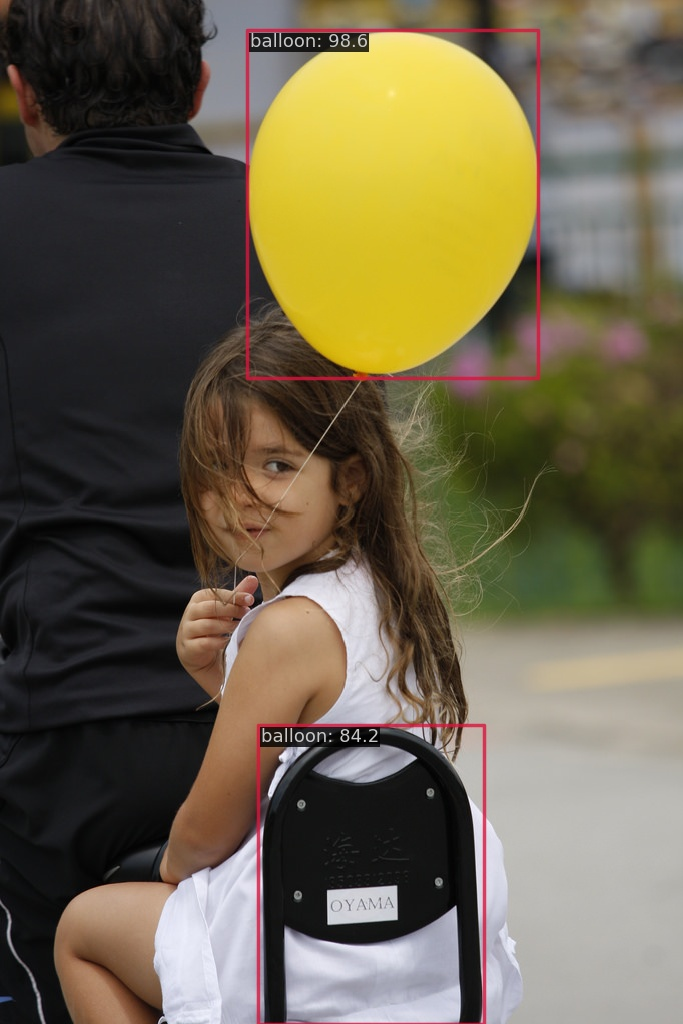

In [20]:
# Show the output image
from PIL import Image
Image.open('./output/vis/5555705118_3390d70abe_b.jpg')